<a href="https://colab.research.google.com/github/SoumyajeetM/ARIMA_Sales_Forecasting/blob/main/AKyle_Round1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import and Cleaning

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#Import the excel file and examine it
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#Investigate missing value
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
#drop missing value
df = df.dropna()
df.shape

(406829, 8)

In [ ]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
# Correcting anomalies in Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
#Cleaning String and data type


df['Description'] = df['Description'].str.replace('.','').str.upper().str.strip()
df['Description'] = df['Description'].replace(r"\s+",' ', regex = True)
df['InvoiceNo'] = df['InvoiceNo'].astype('string')
df['CustomerID'] = df['CustomerID'].astype('string')
df.dtypes

,0
InvoiceNo,string[python]
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,string[python]
Country,object


In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,397884.000000,397884,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 14:39:00,1.950000
75%,12.000000,2011-10-20 14:33:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,179.331775,NaN,22.097877


In [ ]:
#Cleaning Data Frame where StockCode contains space
df['string'] = df.StockCode.str.isalpha()
df = df[df['string'] != False]
df['space'] = df.StockCode.str.contains(' ')
df = df[df['space'] != False]
df = df.drop(columns=['string', 'space'])
df.shape

(363087, 8)

In [ ]:
#Filtering transaction with invoice number started with letter 'C'
df = df[~df.InvoiceNo.str.contains('C')]
df.shape

(363087, 8)

In [ ]:
#Remove ruplicate data in EXACT columns
df.drop_duplicates(inplace = True)
df.shape

(358277, 8)

In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,358277.000000,358277,358277.000000
mean,13.227475,2011-07-12 13:36:41.248587008,2.892641
min,1.000000,2010-12-01 08:26:00,0.040000
25%,2.000000,2011-04-10 11:35:00,1.250000
50%,6.000000,2011-08-02 14:21:00,1.790000
75%,12.000000,2011-10-21 12:05:00,3.750000
max,80995.000000,2011-12-09 12:50:00,649.500000
std,188.617674,NaN,4.383010


In [ ]:
#Finding the IQR of UnitPrice
percentile25 = df['UnitPrice'].quantile(0.25)
percentile75 = df['UnitPrice'].quantile(0.75)
iqr = percentile75 - percentile25
#Finding upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
#Removing Outlier from UnitPrice
new_df = df[(df['UnitPrice'] < upper_limit)  & (df['UnitPrice'] > lower_limit)]
print(df.shape)
print(new_df.shape)

#Finding the IQR of UnitPrice
percentile25 = new_df['Quantity'].quantile(0.25)
percentile75 = new_df['Quantity'].quantile(0.75)
iqr = percentile75 - percentile25
#Finding upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
#Removing Outlier from UnitPrice
new_df = new_df[(new_df['Quantity'] < upper_limit)  & (new_df['Quantity'] > lower_limit)]
print(new_df.shape)

(358277, 8)
(326217, 8)


In [ ]:
#Extract date from datetime column in Pandas
new_df['Date'] = new_df['InvoiceDate'].dt.normalize()
new_df['Year'] = new_df['InvoiceDate'].dt.year
new_df['Month'] = new_df['InvoiceDate'].dt.month_name().str[:3]
new_df['Day'] = new_df['InvoiceDate'].dt.day_name()
new_df['hour'] = new_df['InvoiceDate'].dt.hour
new_df['month_year'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')

new_df['Sales'] = new_df['Quantity'] * new_df['UnitPrice']
new_df.head()

In [ ]:
# Group by 'CustomerID' and count the number of transactions for each customer
customer_transaction_counts = new_df.groupby('CustomerID').size()

# Identify retained customers (those with more than one transaction)
retained_customers = customer_transaction_counts[customer_transaction_counts > 1]

# Number of retained customers
num_retained_customers = retained_customers.shape[0]

# Total number of unique customers
total_customers = customer_transaction_counts.shape[0]

# Calculate the percentage of retained customers
percentage_retained_customers = (num_retained_customers / total_customers) * 100

print(f"Number of retained customers: {num_retained_customers}")
print(f"Percentage of retained customers: {percentage_retained_customers:.2f}%")

Number of retained customers: 4105
Percentage of retained customers: 98.37%


In [ ]:
import pandas as pd
import numpy as np

# Assuming new_df has the columns: InvoiceNo, StockCode, Quantity

# Step 1: Create a Transaction-Product Matrix
basket = new_df.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0)

# Convert the quantities to 1 (purchased) or 0 (not purchased)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Step 2: Compute the Correlation Matrix
correlation_matrix = basket.corr()

# Step 3: Extract the upper triangle of the correlation matrix (excluding the diagonal)
# Get the indices for the upper triangle
upper_triangle_indices = np.triu_indices_from(correlation_matrix, k=1)

# Get the correlated product pairs and their correlation values
product_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
                 for i, j in zip(*upper_triangle_indices) if correlation_matrix.iloc[i, j] > 0.5]

# Step 4: Convert to a DataFrame for easier viewing
high_corr_pairs = pd.DataFrame(product_pairs, columns=['Product1', 'Product2', 'Correlation'])

# Sort by correlation in descending order
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Display highly correlated product pairs
print(high_corr_pairs)


     Product1  Product2  Correlation
394     23071     23072     1.000000
246     22767     22768     1.000000
386     23049     23052     1.000000
529     90043     90048     1.000000
107     22169     22768     1.000000
..        ...       ...          ...
134     22363     22364     0.501295
166     22562     22564     0.501164
494     23512     23515     0.500784
3       20674     20676     0.500250
239     22749     22751     0.500165

[559 rows x 3 columns]


In [ ]:
# Filter the DataFrame for correlations greater than 0.9
high_corr_pairs_filtered = high_corr_pairs[high_corr_pairs['Correlation'] > 0.9]

# Display the top 50 results in a table
pd.set_option('display.max_rows', 50)  # Adjust the number of rows to display if needed

file_path = 'high_corr_pairs_filtered.xlsx'

# Export the filtered DataFrame to an Excel file
high_corr_pairs_filtered.to_excel(file_path, index=False)

print(f"Data exported to {file_path}")

Data exported to high_corr_pairs_filtered.xlsx


# Exploratory Data Analysis

In [ ]:
Sales_Country = new_df.groupby(['Country']).agg({'InvoiceNo': ['nunique'],
                                      'InvoiceNo': 'count', 'Sales':'sum', 'Quantity':'sum'}).rename(columns={'InvoiceNo':'Total_Order'}).sort_values('Sales', ascending=False)
print(Sales_Country.head(10))

                Total_Order       Sales  Quantity
Country                                          
United Kingdom       272691  3352647.62   1970179
Germany                6933   126673.74     78419
France                 6535   115502.90     72293
EIRE                   4919    95928.40     53795
Spain                  1848    27338.06     16934
Switzerland            1312    26943.79     16634
Belgium                1527    25941.26     16325
Portugal               1176    18982.35     11214
Norway                  716    16711.56      8770
Netherlands             576    13980.84      6703


In [ ]:
Foreign_Sales = Sales_Country.reset_index().query('Country != "United Kingdom"')
Foreign_Sales.head(10)

,Country,Total_Order,Sales,Quantity
1,Germany,6933,126673.74,78419
2,France,6535,115502.90,72293
3,EIRE,4919,95928.40,53795
4,Spain,1848,27338.06,16934
5,Switzerland,1312,26943.79,16634
6,Belgium,1527,25941.26,16325
7,Portugal,1176,18982.35,11214
8,Norway,716,16711.56,8770
9,Netherlands,576,13980.84,6703
10,Australia,466,11709.71,4864


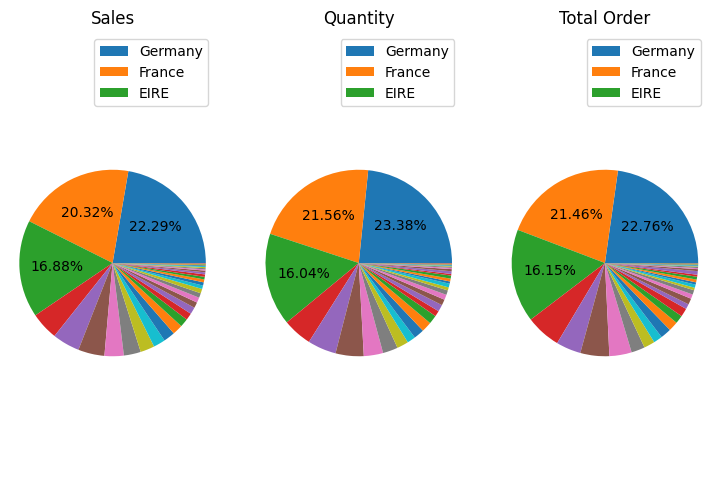

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,6))

def autopct(pct):
    return ('%1.2f%%' % pct) if pct > 15 else ''

p,t,a = ax1.pie(Foreign_Sales.Sales, autopct=autopct)
p,t,a = ax2.pie(Foreign_Sales.Quantity, autopct=autopct)
p,t,a = ax3.pie(Foreign_Sales.Total_Order, autopct=autopct)
ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')
# normalize dataframe (not actually needed here, but for general case)
normsizes = Foreign_Sales.Sales/Foreign_Sales.Sales.sum()*100
normsizes2 = Foreign_Sales.Quantity/Foreign_Sales.Quantity.sum()*100
normsizes3 = Foreign_Sales.Total_Order/Foreign_Sales.Total_Order.sum()*100
# create handles and labels for legend, take only those where value is > 1
h,l = zip(*[(h,lab) for h,lab,i in zip(p,Foreign_Sales.Country.values,normsizes.values) if i > 15])
h,j = zip(*[(h,lab) for h,lab,i in zip(p,Foreign_Sales.Country.values,normsizes2.values) if i > 15])
h,k = zip(*[(h,lab) for h,lab,i in zip(p,Foreign_Sales.Country.values,normsizes3.values) if i > 15])
ax1.set_title('Sales')
ax2.set_title('Quantity')
ax3.set_title('Total Order')
ax1.legend(h, l,loc="best", bbox_to_anchor=(1,1))
ax2.legend(h, j,loc="best", bbox_to_anchor=(1,1))
ax3.legend(h, k,loc="best", bbox_to_anchor=(1,1))
plt.show()

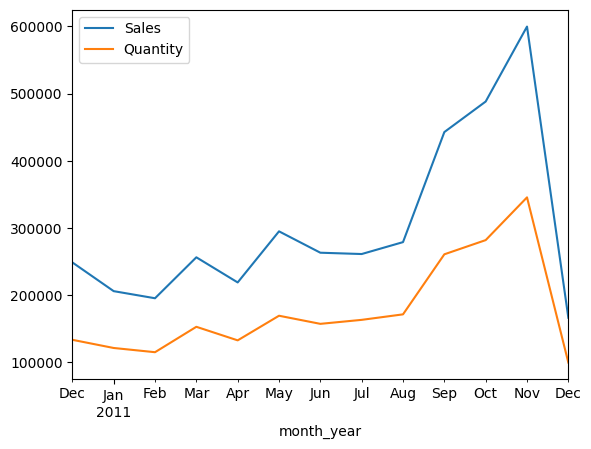

In [ ]:
Sales_MoM = pd.DataFrame(new_df.groupby(['month_year']).agg({'Sales':'sum', 'Quantity':'sum'})).reset_index()
Sales_MoM.plot(x='month_year');

In [ ]:
Sales_Product = new_df.groupby(['Description']).agg({'InvoiceNo': ['nunique'],
                                      'InvoiceNo': 'count', 'Sales':'sum'}).rename(columns={'InvoiceNo':'Total_Order'}).sort_values('Sales', ascending=False)[0:20]
Quantity_Product = new_df.groupby(['Description']).agg({'InvoiceNo': ['nunique'],
                                      'InvoiceNo': 'count', 'Quantity':'sum'}).rename(columns={'InvoiceNo':'Total_Order'}).sort_values('Quantity', ascending=False)[0:20]
print(Sales_Product)
print(Quantity_Product)

                                  Total_Order     Sales
Description                                            
PARTY BUNTING                            1267  34952.85
SPOTTY BUNTING                            972  23379.40
ASSORTED COLOUR BIRD ORNAMENT            1144  22848.80
JAM MAKING SET WITH JARS                  823  21137.25
HOT WATER BOTTLE KEEP CALM                723  20617.35
SET OF 3 CAKE TINS PANTRY DESIGN         1113  20583.97
CHILLI LIGHTS                             443  18379.80
CHOCOLATE HOT WATER BOTTLE                684  18308.10
RETROSPOT TEA SET CERAMIC 11 PC           806  17941.60
NATURAL SLATE HEART CHALKBOARD            936  17750.77
PAPER CHAIN KIT 50'S CHRISTMAS            866  17455.71
ROSES REGENCY TEACUP AND SAUCER           756  16284.75
BAKING SET 9 PIECE RETROSPOT              829  16263.00
LUNCH BAG RED RETROSPOT                  1195  16194.80
ALARM CLOCK BAKELIKE RED                  860  15785.61
SET OF 3 REGENCY CAKE TINS                684  1

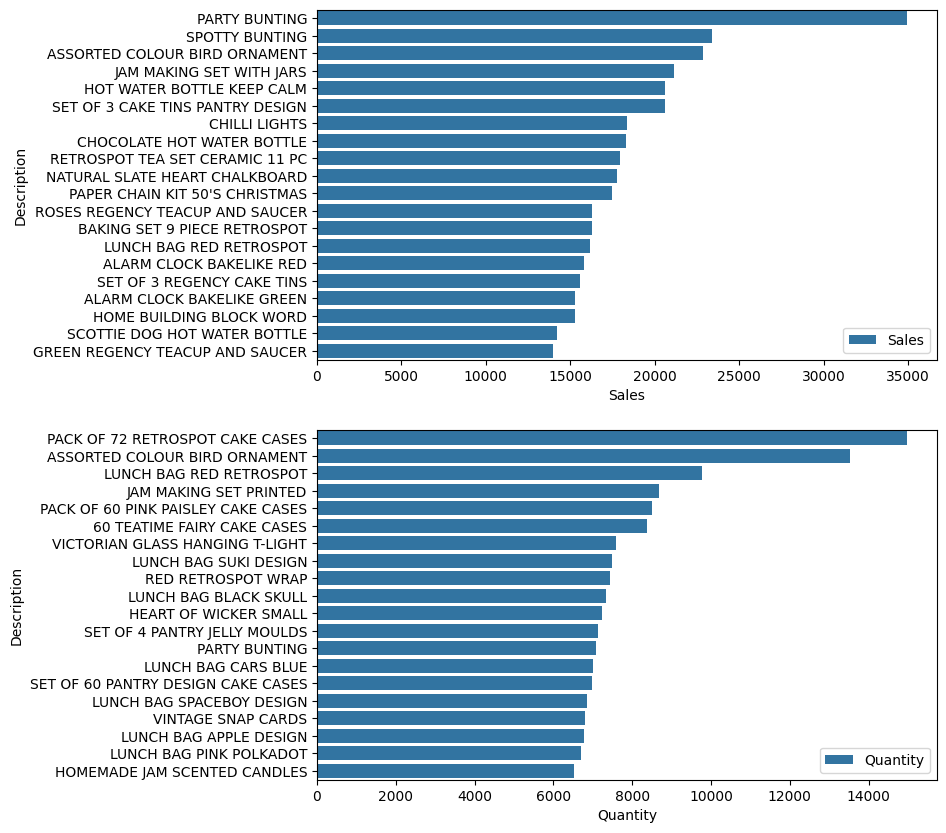

In [ ]:
fig, axes = plt.subplots(2,figsize=(8, 10))
sns.barplot(x='Sales', y=Sales_Product.index, data = Sales_Product,
            label="Sales", ax=axes[0])
sns.barplot(x='Quantity', y=Quantity_Product.index, data=Quantity_Product,
            label="Quantity", ax=axes[1])
plt.show()

In [ ]:
Quantity_Sales = Quantity_Product.merge(Sales_Product, left_index=True, right_index=True, how='inner')
Quantity_Sales

,Total_Order_x,Quantity,Total_Order_y,Sales
Description,,,,
ASSORTED COLOUR BIRD ORNAMENT,1144,13520,1144,22848.8


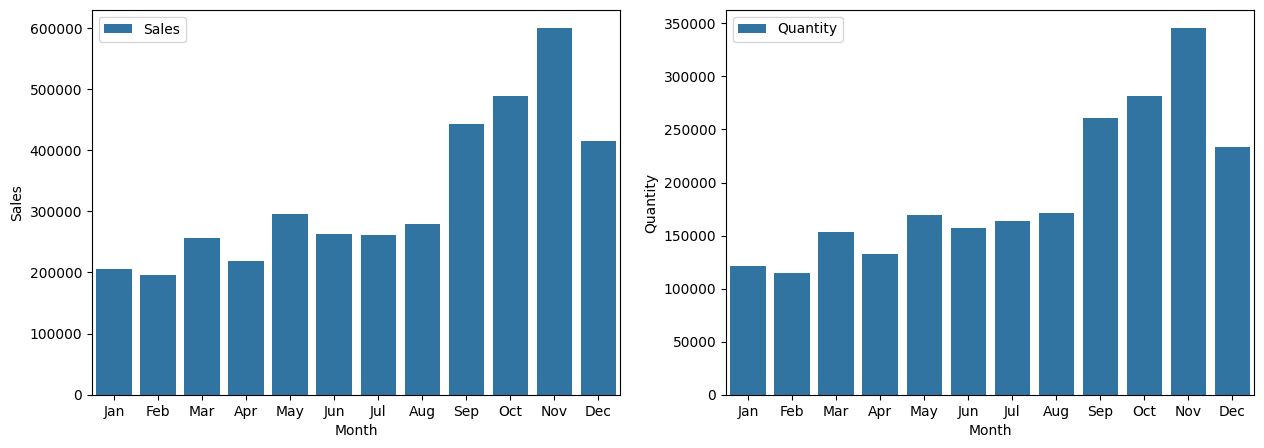

In [ ]:
Monthly_Sales = new_df.groupby(['Month']).agg({'Sales':'sum', 'Quantity':'sum'})
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Monthly_Sales = Monthly_Sales.reindex(months_ordered)
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=Monthly_Sales.index, y='Sales', data = Monthly_Sales,
            label="Sales", ax=axes[0])
sns.barplot(x=Monthly_Sales.index, y='Quantity', data = Monthly_Sales,
            label="Quantity", ax=axes[1])
plt.show()

In [ ]:
# Get unique values from the 'Day' column in new_df
unique_days = new_df['Day'].unique()

# Print unique values
print(unique_days)

['Wednesday' 'Thursday' 'Friday' 'Sunday' 'Monday' 'Tuesday']


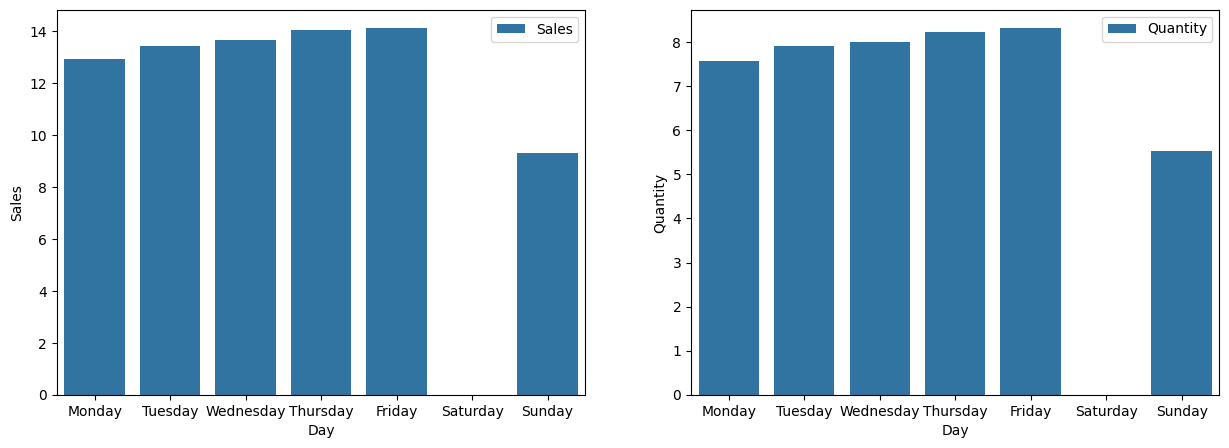

In [ ]:
Day_Sales = new_df.groupby(['Day']).agg({'Sales':'mean', 'Quantity':'mean'})
day_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
Day_Sales = Day_Sales.reindex(day_ordered)
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=Day_Sales.index, y='Sales', data = Day_Sales,
            label="Sales", ax=axes[0])
sns.barplot(x=Day_Sales.index, y='Quantity', data = Day_Sales,
            label="Quantity", ax=axes[1])
plt.show()

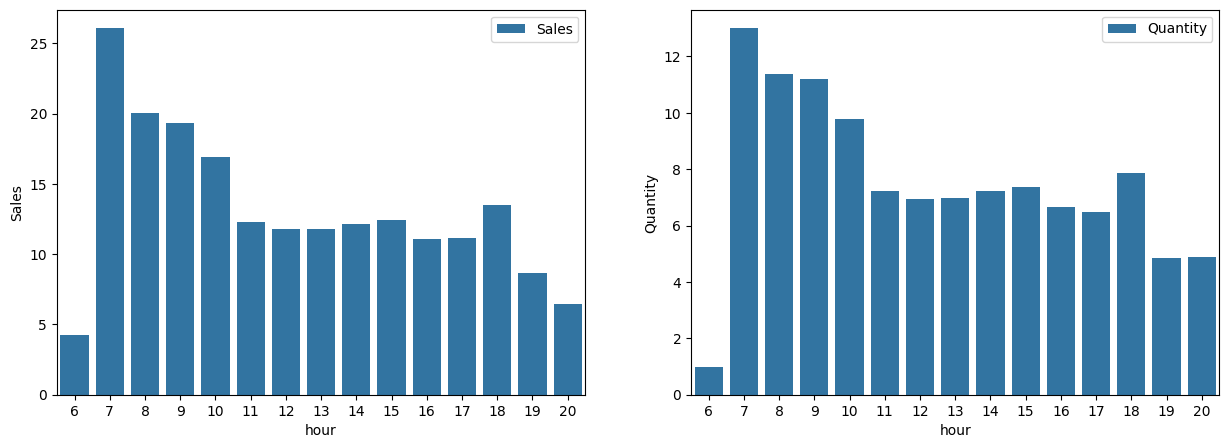

In [ ]:
Hour_Sales = new_df.groupby(['hour']).agg({'Sales':'mean', 'Quantity':'mean'})
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=Hour_Sales.index, y='Sales', data = Hour_Sales,
            label="Sales", ax=axes[0])
sns.barplot(x=Hour_Sales.index, y='Quantity', data = Hour_Sales,
            label="Quantity", ax=axes[1])
plt.show()

In [ ]:
Sales_Customer = new_df.groupby(['CustomerID']).agg({'Sales':'sum'}).sort_values('Sales', ascending=False)[0:10]
Quantity_Customer = new_df.groupby(['CustomerID']).agg({'Quantity':'sum'}).sort_values('Quantity', ascending=False)[0:10]
print(Sales_Customer)
print(Quantity_Customer)

               Sales
CustomerID          
14911.0     76424.67
13089.0     32957.08
14096.0     32949.41
17841.0     29176.25
14298.0     20823.48
12748.0     18388.33
14156.0     17179.68
13081.0     16012.81
15311.0     14220.87
17675.0     13717.15
            Quantity
CustomerID          
14911.0        45062
13089.0        18858
17841.0        17602
14298.0        14482
12748.0        13372
14096.0        11819
13081.0        11037
14156.0         7422
17735.0         7197
12921.0         7174


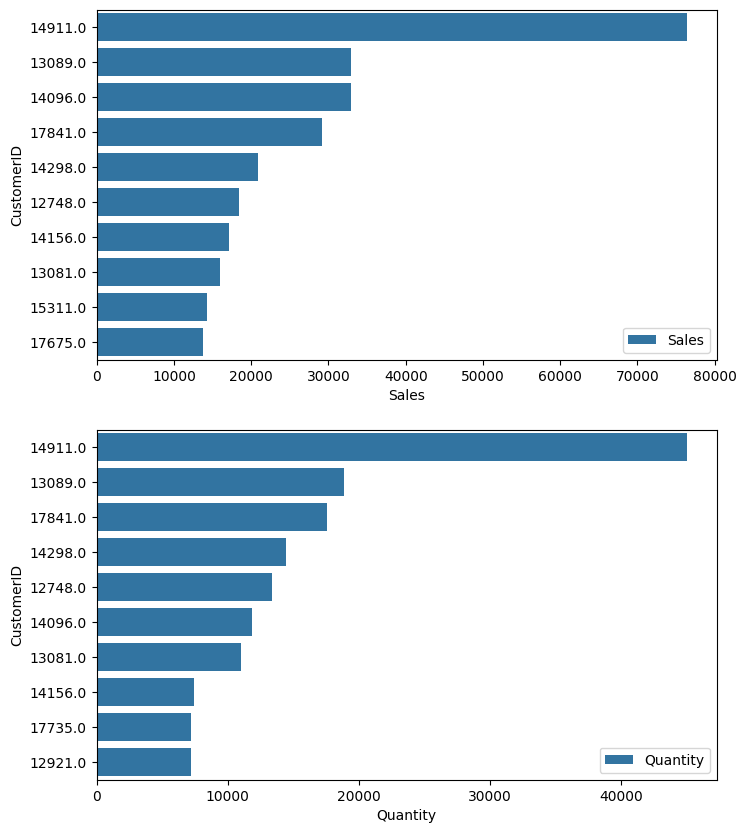

In [ ]:
fig, axes = plt.subplots(2,figsize=(8, 10))
sns.barplot(x='Sales', y=Sales_Customer.index, data = Sales_Customer,
            label="Sales", ax=axes[0])
sns.barplot(x='Quantity', y=Quantity_Customer.index, data=Quantity_Customer,
            label="Quantity", ax=axes[1])
plt.show()

In [ ]:
Customer_Order = new_df.groupby('CustomerID').agg({'InvoiceNo': ['nunique'],
                                      'InvoiceNo': 'count', 'Sales':'sum'}).rename(columns={'InvoiceNo':'Total_Order'}).sort_values('Total_Order', ascending=False)[0:10]
Customer_Order

,Total_Order,Sales
CustomerID,,
17841.0,6504,29176.25
14911.0,4041,76424.67
14096.0,3968,32949.41
12748.0,3634,18388.33
14606.0,2087,6845.35
15311.0,1631,14220.87
13263.0,1435,5970.94
13089.0,1397,32957.08
15039.0,1086,11738.60


In [ ]:
customer_arpu = new_df.groupby('CustomerID').agg({'InvoiceNo': ['nunique'],
                                      'InvoiceNo': 'count', 'Sales':'sum'}).rename(columns={'InvoiceNo':'Total_Order'})
customer_arpu['arpu'] = customer_arpu.Sales / customer_arpu.Total_Order
print(customer_arpu.describe())

       Total_Order         Sales         arpu
count  4173.000000   4173.000000  4173.000000
mean     72.644620    939.617012    16.635910
std     180.911953   1997.793054    11.447857
min       1.000000      1.900000     0.735217
25%      13.000000    179.440000     9.553939
50%      33.000000    425.770000    15.995000
75%      80.000000   1050.270000    19.379038
max    6504.000000  76424.670000   166.800000


In [ ]:
df.info()

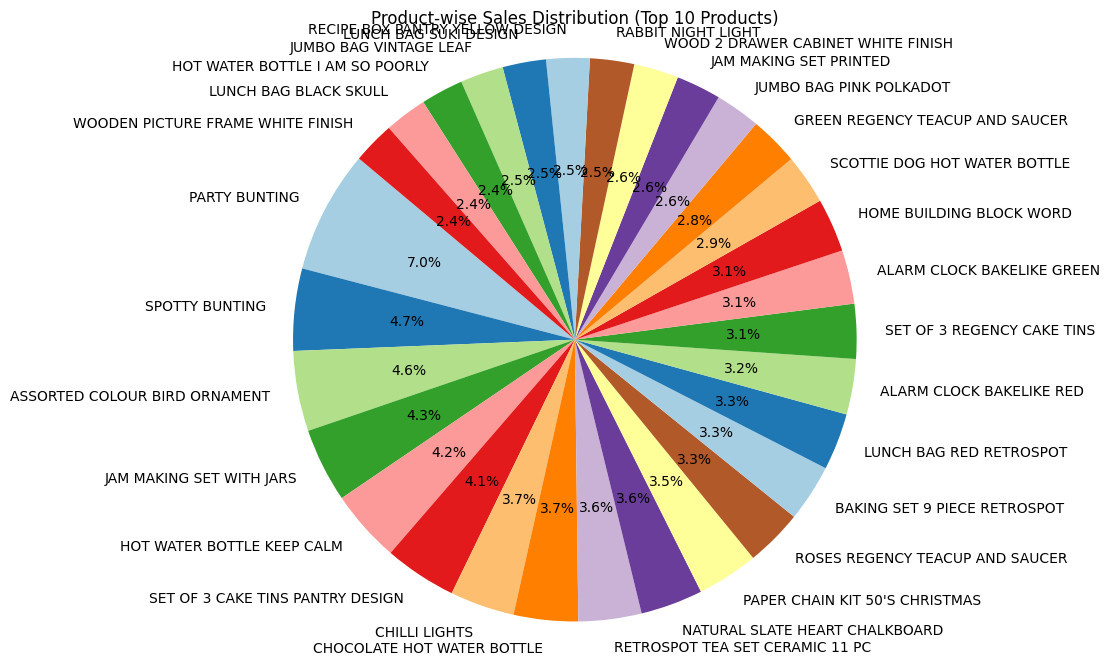

In [ ]:
import matplotlib.pyplot as plt

# Aggregate sales by product
product_sales = new_df.groupby('Description')['Sales'].sum()

# Plot the pie chart for the top products based on sales
top_products_sales = product_sales.nlargest(30)  # Display top 10 products for better visualization

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_products_sales, labels=top_products_sales.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Add a title
plt.title("Product-wise Sales Distribution (Top 10 Products)")

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


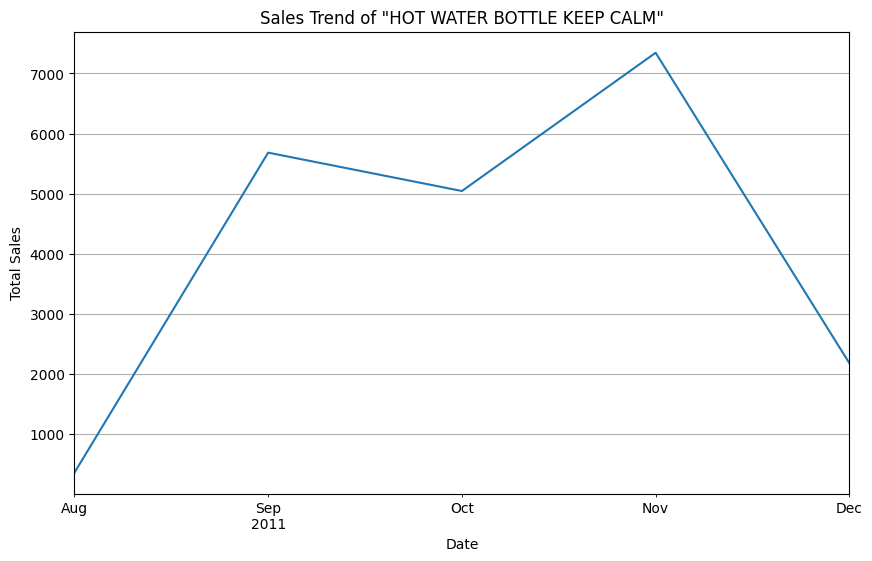

In [ ]:
import matplotlib.pyplot as plt

# Filter data for the product "PARTY BUNTING"
party_bunting_data = new_df[new_df['Description'] == 'HOT WATER BOTTLE KEEP CALM']

# Aggregate the sales by date (assuming 'Date' column exists)
party_bunting_sales = party_bunting_data.resample('M', on='Date')['Sales'].sum()

# Plot the sales trend
plt.figure(figsize=(10, 6))
party_bunting_sales.plot()

# Add labels and title
plt.title('Sales Trend of "HOT WATER BOTTLE KEEP CALM"')
plt.xlabel('Date')
plt.ylabel('Total Sales')

# Show the plot
plt.grid(True)
plt.show()


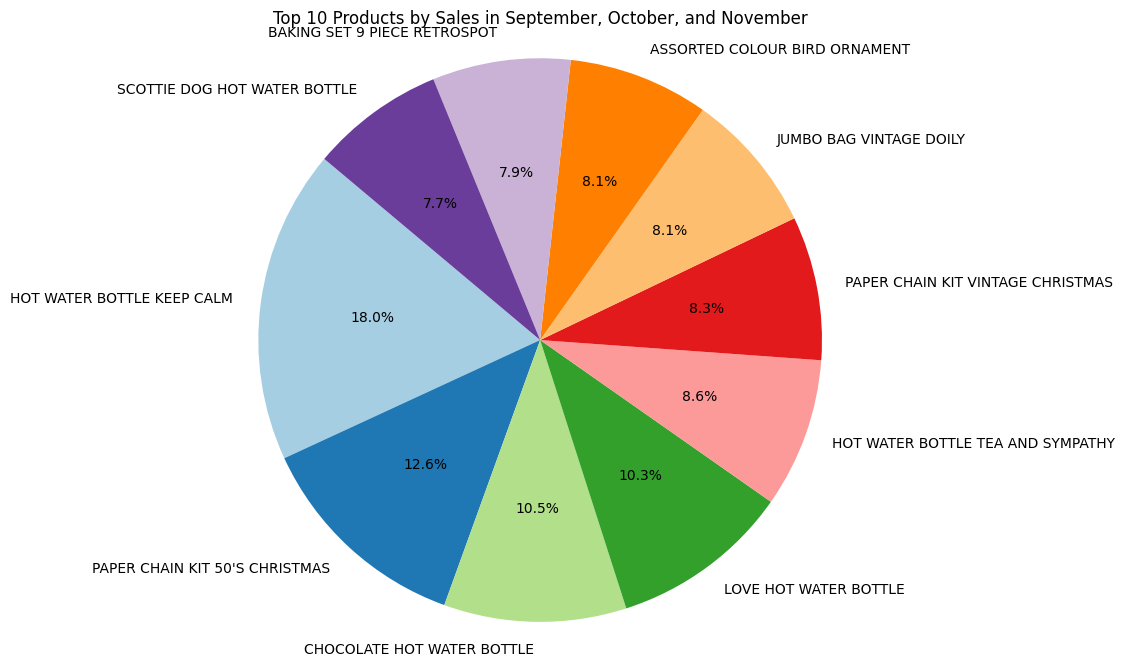

In [ ]:
import matplotlib.pyplot as plt

# Filter data for September, October, and November
fall_data = new_df[new_df['Date'].dt.month.isin([9, 10, 11])]

# Aggregate sales by product description
fall_sales = fall_data.groupby('Description')['Sales'].sum()

# Sort the products by sales and select the top 10
top_fall_sales = fall_sales.sort_values(ascending=False).head(10)

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_fall_sales, labels=top_fall_sales.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Add title
plt.title('Top 10 Products by Sales in September, October, and November')

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


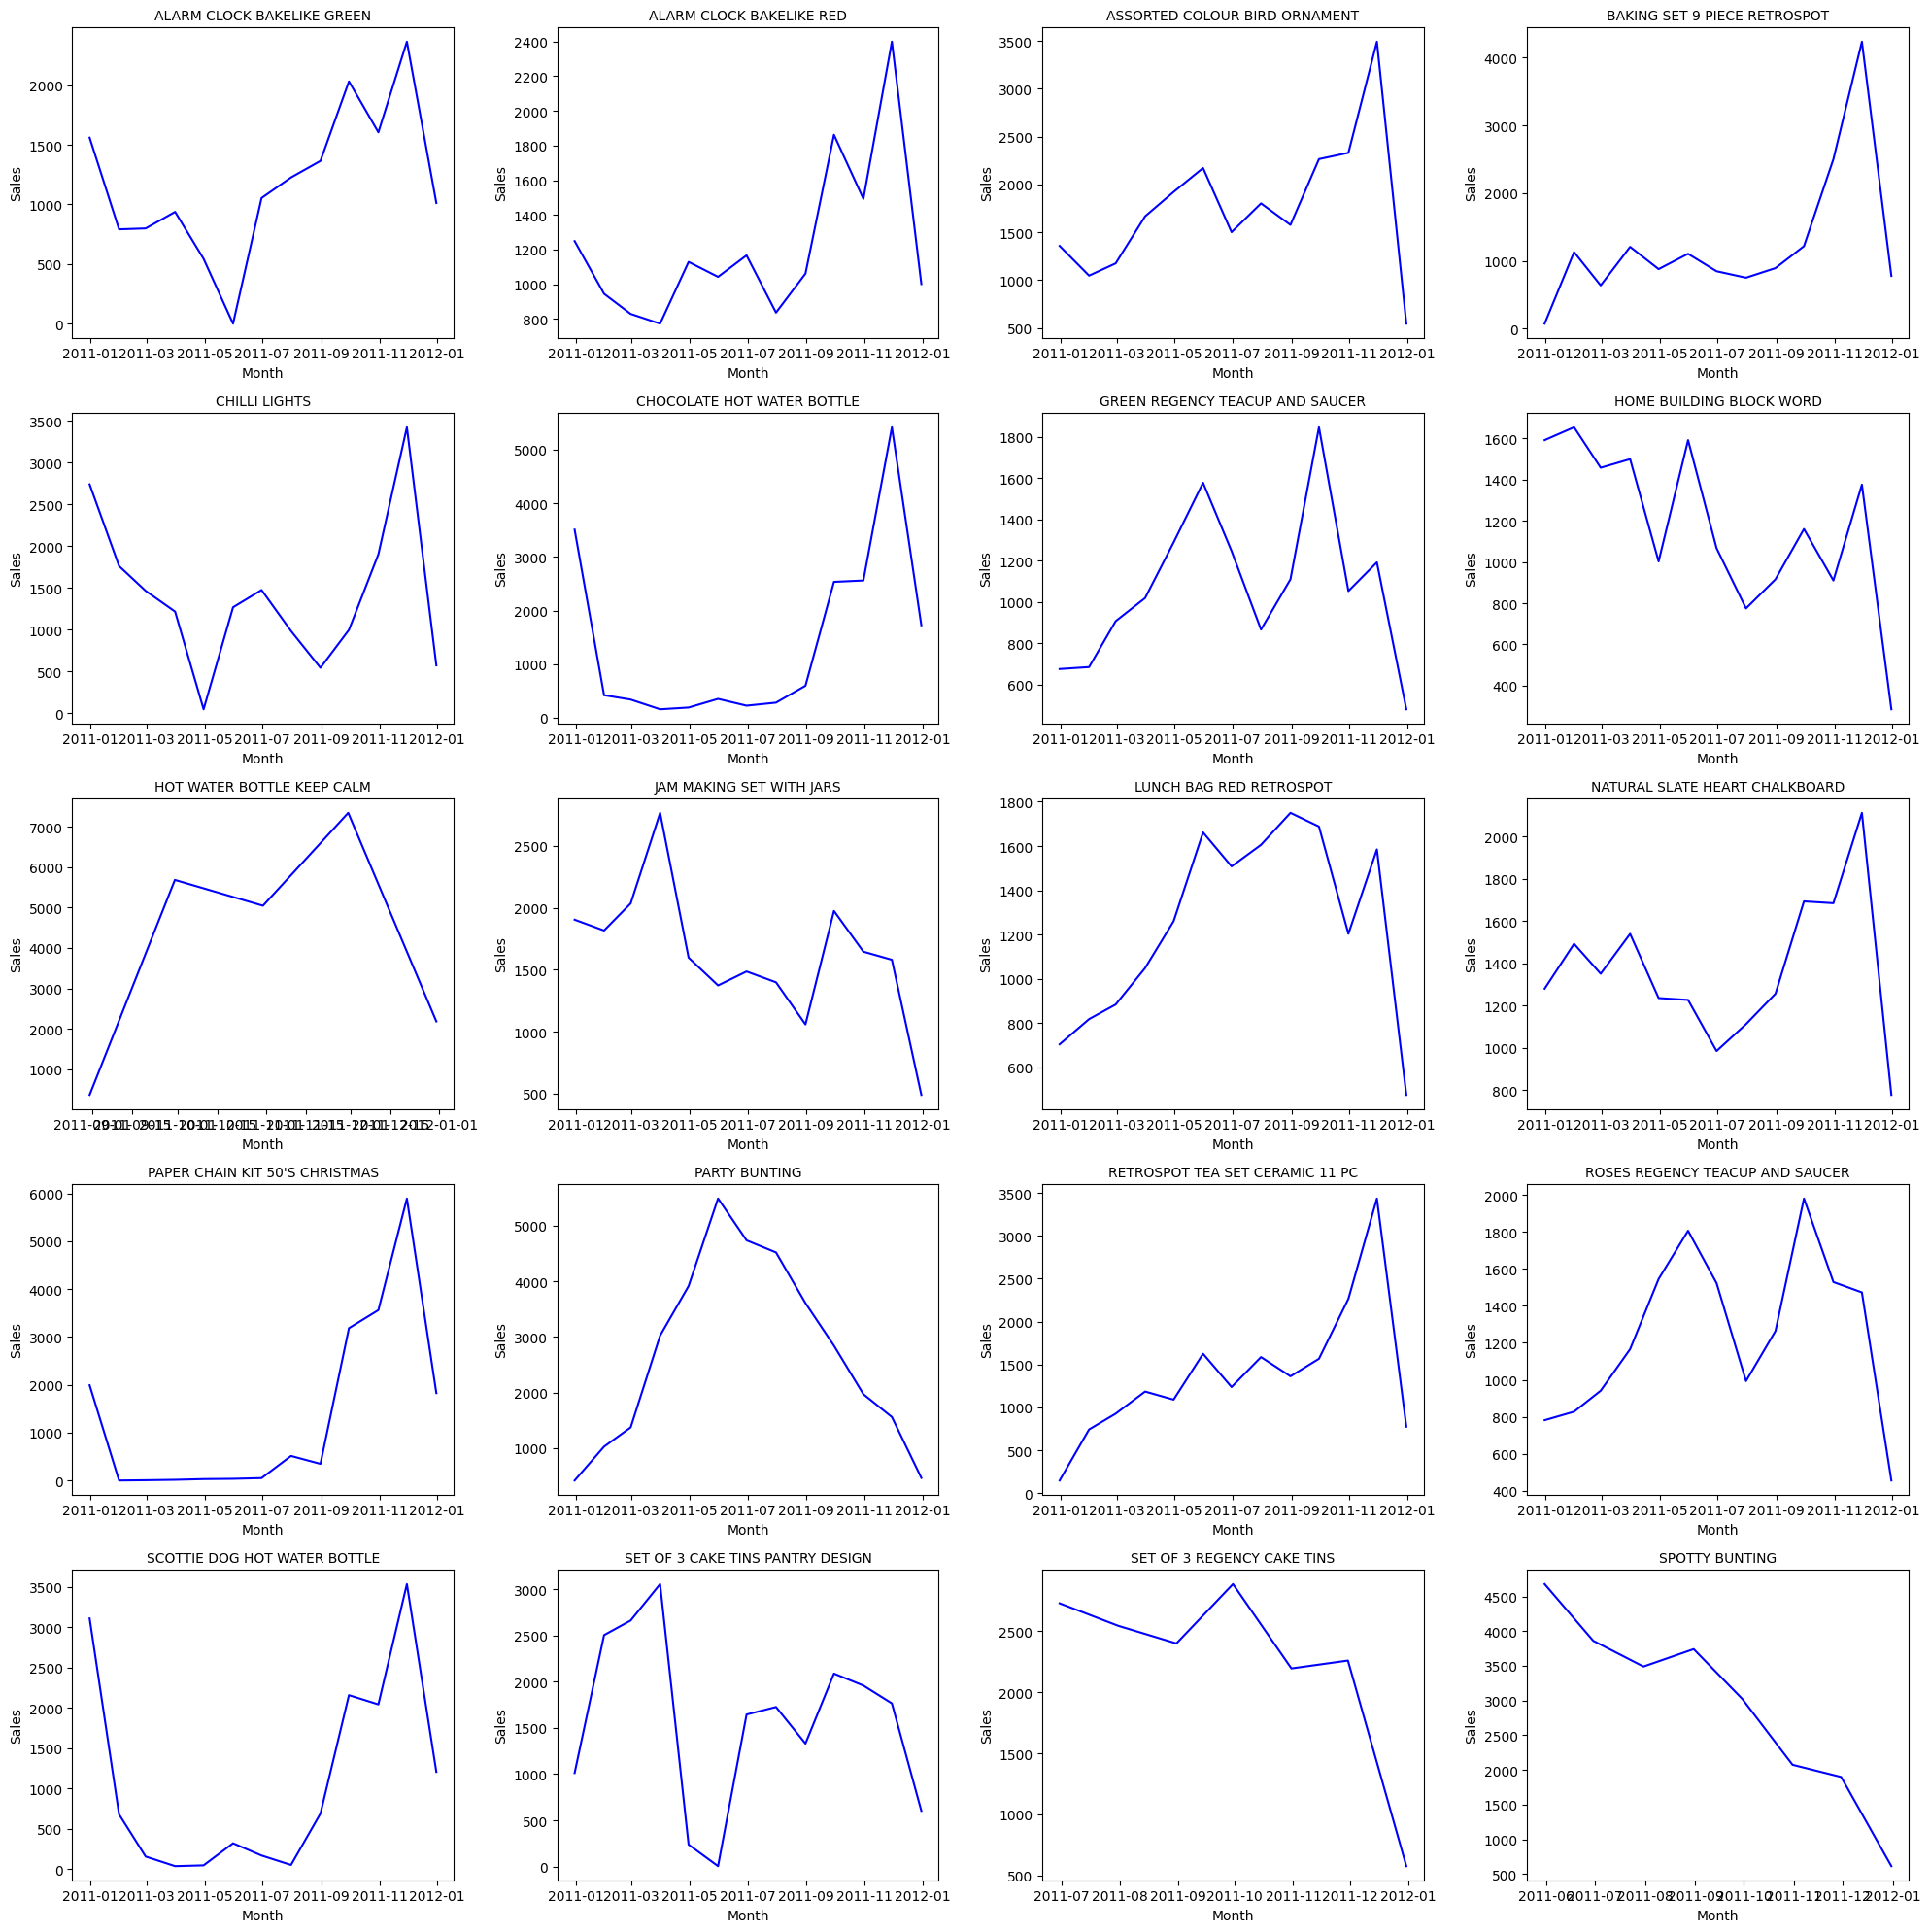

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 20 most selling products based on total sales
top_20_products = new_df.groupby('Description')['Sales'].sum().sort_values(ascending=False).head(20).index

# Filter the dataframe to include only the top 20 products
top_20_data = new_df[new_df['Description'].isin(top_20_products)]

# Convert 'Date' to datetime if not already in datetime format
top_20_data['Date'] = pd.to_datetime(top_20_data['Date'])

# Resample to monthly frequency, grouping by 'Description' and 'Date', and summing the sales
top_20_monthly_trends = top_20_data.set_index('Date').groupby('Description').resample('M')['Sales'].sum().unstack('Description')

# Plotting: Create a grid of subplots for the top 20 products
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))  # 5 rows x 4 columns

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot monthly sales trends for each product in its respective subplot
for i, product in enumerate(top_20_monthly_trends.columns):
    sns.lineplot(data=top_20_monthly_trends[product], ax=axes[i], color='blue')
    axes[i].set_title(product, fontsize=10)
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Sales')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd

# Assuming 'new_df' has the necessary columns: 'CustomerID', 'InvoiceNo', 'Quantity', 'UnitPrice', 'Description', and 'Sales'

# Customer Metrics
customer_data = new_df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Number of unique visits (invoices)
    'Sales': 'sum'  # Total spend per customer
})

# Average Purchase Frequency
avg_purchase_frequency = customer_data['InvoiceNo'].mean()

# Average Spend per Visit
customer_data['Avg_Spend_Per_Visit'] = customer_data['Sales'] / customer_data['InvoiceNo']
avg_spend_per_visit = customer_data['Avg_Spend_Per_Visit'].mean()

# Total Spend per Customer
total_spend_per_customer = customer_data['Sales'].sum()

# Product Metrics
product_data = new_df.groupby('Description').agg({
    'Quantity': 'sum',  # Total sales volume (quantity sold per product)
    'UnitPrice': 'mean',  # Average price of each product
    'Sales': 'sum'  # Total sales revenue per product
})

# Average Stock Turn Rate (Total sales quantity / Unique products)
avg_stock_turn_rate = product_data['Quantity'].sum() / len(product_data)

# Average Price of All Products
avg_price_all_products = product_data['UnitPrice'].mean()

# Sales Volume per Product
sales_volume_per_product = product_data['Quantity']

# Output Metrics
print(f"Average Purchase Frequency: {avg_purchase_frequency:.2f}")
print(f"Average Spend per Visit: {avg_spend_per_visit:.2f}")
print(f"Total Spend per Customer: {total_spend_per_customer:.2f}")
print(f"Average Stock Turn Rate: {avg_stock_turn_rate:.2f}")
print(f"Average Price of All Products: {avg_price_all_products:.2f}")
print(f"Sales Volume per Product:\n{sales_volume_per_product.head()}")


Average Purchase Frequency: 3.99
Average Spend per Visit: 229.93
Total Spend per Customer: 3921021.79
Average Stock Turn Rate: 842.97
Average Price of All Products: 2.30
Sales Volume per Product:
Description
10 COLOUR SPACEBOY PEN              3927
12 COLOURED PARTY BALLOONS          1701
12 DAISY PEGS IN WOOD BOX            322
12 HANGING EGGS HAND PAINTED          40
12 IVORY ROSE PEG PLACE SETTINGS     713
Name: Quantity, dtype: int64


In [ ]:
import pandas as pd

# Assuming 'new_df' has the necessary columns: 'CustomerID', 'InvoiceNo', 'Quantity', 'UnitPrice', 'Sales'

# Calculate total spend per customer by grouping by 'CustomerID'
customer_data = new_df.groupby('CustomerID').agg({
    'Sales': 'sum',  # Total spend per customer
    'InvoiceNo': 'nunique'  # Number of unique visits (invoices)
})

# Average Purchase Frequency (mean number of visits per customer)
avg_purchase_frequency = customer_data['InvoiceNo'].mean()

# Average Spend per Visit (total sales per visit)
customer_data['Avg_Spend_Per_Visit'] = customer_data['Sales'] / customer_data['InvoiceNo']
avg_spend_per_visit = customer_data['Avg_Spend_Per_Visit'].mean()

# Calculate average total spend per customer (the average of total spend across all customers)
avg_total_spend_per_customer = customer_data['Sales'].mean()

# Output Metrics
print(f"Average Purchase Frequency: {avg_purchase_frequency:.2f}")
print(f"Average Spend per Visit: {avg_spend_per_visit:.2f}")
print(f"Average Total Spend per Customer: {avg_total_spend_per_customer:.2f}")


Average Purchase Frequency: 3.99
Average Spend per Visit: 229.93
Average Total Spend per Customer: 939.62


# **Model Development for Prediction**

In [ ]:
#Doing same as above
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#Import the excel file and examine it
df = pd.read_excel('Online Retail.xlsx')

df = df.dropna()

# Correcting anomalies in Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
#Cleaning String and data type


df['Description'] = df['Description'].str.replace('.','').str.upper().str.strip()
df['Description'] = df['Description'].replace(r"\s+",' ', regex = True)
df['InvoiceNo'] = df['InvoiceNo'].astype('string')
df['CustomerID'] = df['CustomerID'].astype('string')

#Cleaning Data Frame where StockCode contains space
df['string'] = df.StockCode.str.isalpha()
df = df[df['string'] != False]
df['space'] = df.StockCode.str.contains(' ')
df = df[df['space'] != False]
df = df.drop(columns=['string', 'space'])

df.drop_duplicates(inplace = True)

#Finding the IQR of UnitPrice
percentile25 = df['UnitPrice'].quantile(0.25)
percentile75 = df['UnitPrice'].quantile(0.75)
iqr = percentile75 - percentile25
#Finding upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
#Removing Outlier from UnitPrice
new_df = df[(df['UnitPrice'] < upper_limit)  & (df['UnitPrice'] > lower_limit)]

#Finding the IQR of UnitPrice
percentile25 = new_df['Quantity'].quantile(0.25)
percentile75 = new_df['Quantity'].quantile(0.75)
iqr = percentile75 - percentile25
#Finding upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
#Removing Outlier from UnitPrice
new_df = new_df[(new_df['Quantity'] < upper_limit)  & (new_df['Quantity'] > lower_limit)]

#Extract date from datetime column in Pandas
new_df['Date'] = new_df['InvoiceDate'].dt.normalize()
new_df['Year'] = new_df['InvoiceDate'].dt.year
new_df['Month'] = new_df['InvoiceDate'].dt.month_name().str[:3]
new_df['Day'] = new_df['InvoiceDate'].dt.day_name()
new_df['hour'] = new_df['InvoiceDate'].dt.hour
new_df['month_year'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')

new_df['Sales'] = new_df['Quantity'] * new_df['UnitPrice']

In [ ]:
#model Development
# Load data
df = new_df

In [ ]:
# Create a new column for 'Month' based on 'InvoiceDate'
df['Month'] = df['InvoiceDate'].dt.month

# Filter data for January, February, and March
jan_to_march_data = df[df['Month'].isin([1, 2, 3])]

# Pivot table to get quantities for January, February, and March as columns
pivot_table = jan_to_march_data.pivot_table(
    index='StockCode',
    columns='Month',
    values='Quantity',
    aggfunc='sum',
    fill_value=0  # Fill missing values with 0 for months with no sales
)

# Rename the columns for clarity
pivot_table.columns = ['January', 'February', 'March']

# Add a 'Total' column summing up the quantities across January, February, and March
pivot_table['Total'] = pivot_table.sum(axis=1)

# Sort the table by the 'Total' column in descending order
pivot_table_sorted = pivot_table.sort_values(by='Total', ascending=False)

# Display the top 10 products by total quantity sold
top_10_products = pivot_table_sorted.head(10)

# Display the result
print(top_10_products)

# Specify the file name and path
file_path = "top_10_products_jan_to_march.xlsx"

# Export the top 10 products to an Excel file
top_10_products.to_excel(file_path, sheet_name='Top 10 Products')

print(f"The top 10 products table has been successfully exported to {file_path}")


           January  February  March  Total
StockCode                                 
21212          926      1144   1511   3581
22961          727       718   1075   2520
84879          619       695    986   2300
21977          491       598   1104   2193
84991          614       551    892   2057
22969          651       612    672   1935
21985         1044       341    371   1756
22720          526       563    634   1723
84992          884       359    443   1686
22469          736       792    156   1684
The top 10 products table has been successfully exported to top_10_products_jan_to_march.xlsx


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303146 entries, 1 to 541908
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    303146 non-null  string        
 1   StockCode    303146 non-null  object        
 2   Description  303146 non-null  object        
 3   Quantity     303146 non-null  int64         
 4   InvoiceDate  303146 non-null  datetime64[ns]
 5   UnitPrice    303146 non-null  float64       
 6   CustomerID   303146 non-null  string        
 7   Country      303146 non-null  object        
 8   Date         303146 non-null  datetime64[ns]
 9   Year         303146 non-null  int32         
 10  Month        303146 non-null  object        
 11  Day          303146 non-null  object        
 12  hour         303146 non-null  int32         
 13  month_year   303146 non-null  period[M]     
 14  Sales        303146 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int32

Forecasted Quantities for Next 3 Months:
2012-01-31    186268.982189
2012-02-29    194598.626400
2012-03-31    195400.167342
Freq: M, Name: predicted_mean, dtype: float64

Confidence Intervals:
            lower Quantity  upper Quantity
2012-01-31    24892.354669   347645.609709
2012-02-29    11547.993542   377649.259258
2012-03-31    -4044.027025   394844.361708


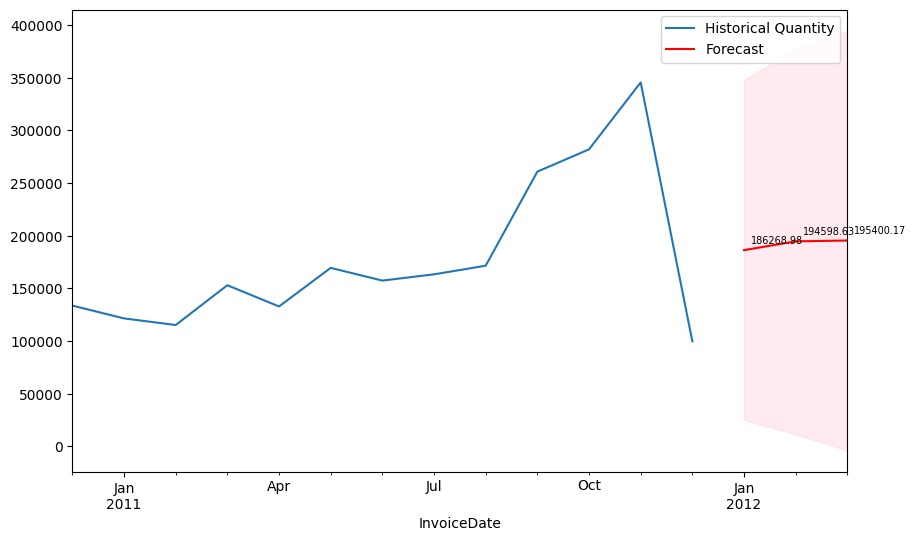

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'df' is your DataFrame and 'InvoiceDate' is the datetime column
df.set_index('InvoiceDate', inplace=True)

# Resample data to monthly frequency and sum the quantities sold
monthly_quantity = df['Quantity'].resample('M').sum()

# Fit ARIMA model (this assumes that you have chosen the order previously)
arima_model = ARIMA(monthly_quantity, order=(1, 1, 1))  # You can adjust the order
arima_result = arima_model.fit()

# Forecast for the next 3 months
forecast_arima = arima_result.get_forecast(steps=3)

# Get confidence intervals
forecast_ci = forecast_arima.conf_int()

# Print forecasted quantities and confidence intervals
print("Forecasted Quantities for Next 3 Months:")
print(forecast_arima.predicted_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

# Plot the forecast along with historical data
ax = monthly_quantity.plot(label='Historical Quantity', figsize=(10, 6))
forecast_arima.predicted_mean.plot(ax=ax, label='Forecast', color='red')

# Fill the confidence interval
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

# Annotate the forecasted values near the vertices
for x, y in zip(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean):
    ax.annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                textcoords='offset points', color='black', fontsize=7)

# Add legend and show plot
plt.legend()
plt.show()

In [ ]:
# Assuming df is your DataFrame with 'InvoiceDate' and 'Sales' columns
df.set_index('Date', inplace=True)

# Resample the data to monthly frequency, summing sales for each month
monthly_sales = df['Sales'].resample('M').sum()

# Display the aggregated monthly sales data
print(monthly_sales.head())


Date
2010-12-31    248769.67
2011-01-31    206004.73
2011-02-28    195439.22
2011-03-31    256379.86
2011-04-30    218962.49
Freq: M, Name: Sales, dtype: float64


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -158.869
Date:                Thu, 22 Aug 2024   AIC                            323.738
Time:                        14:51:53   BIC                            325.192
Sample:                    12-31-2010   HQIC                           323.199
                         - 12-31-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1366      2.715      0.050      0.960      -5.185       5.458
ma.L1         -0.6110      1.665     -0.367      0.714      -3.874       2.652
sigma2       2.42e+10   1.25e-10   1.94e+20      0.0

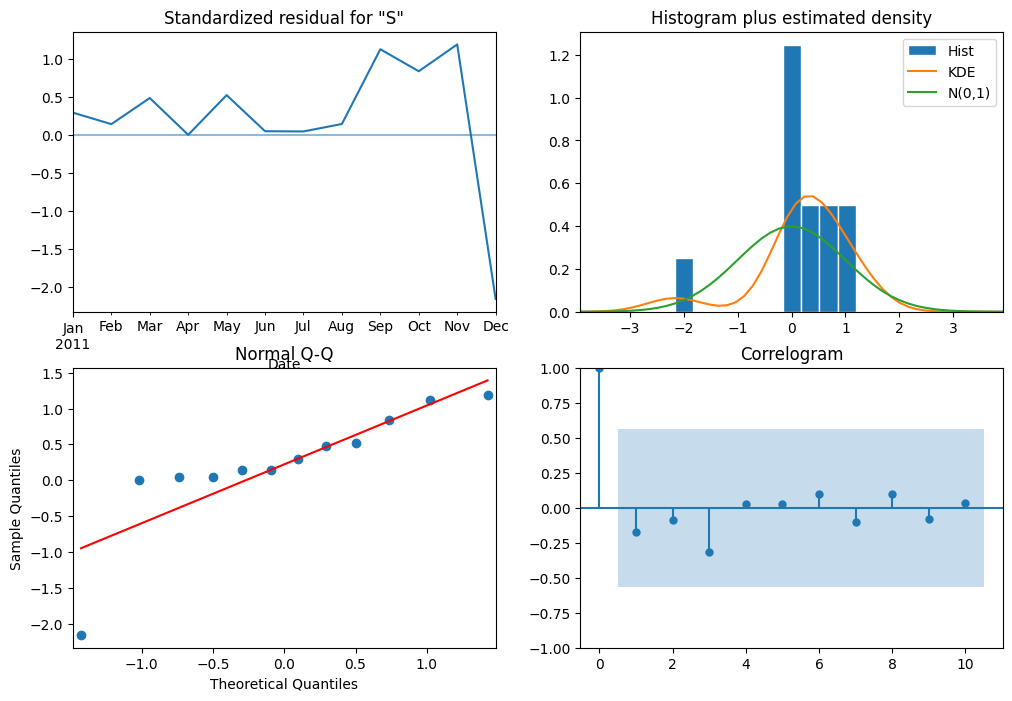

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Define the model (you may need to tune the (p, d, q) parameters)
arima_model = ARIMA(monthly_sales, order=(1, 1, 1))  # (p, d, q)

# Fit the model
arima_result = arima_model.fit()

# Summary of the model
print(arima_result.summary())

# Plot the diagnostics to check the model's assumptions
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()


2012-01-31    312338.494104
2012-02-29    332266.994739
2012-03-31    334988.876402
Freq: M, Name: predicted_mean, dtype: float64
             lower Sales    upper Sales
2012-01-31   7420.558322  617256.429885
2012-02-29 -12195.549109  676729.538586
2012-03-31 -37021.296257  706999.049062


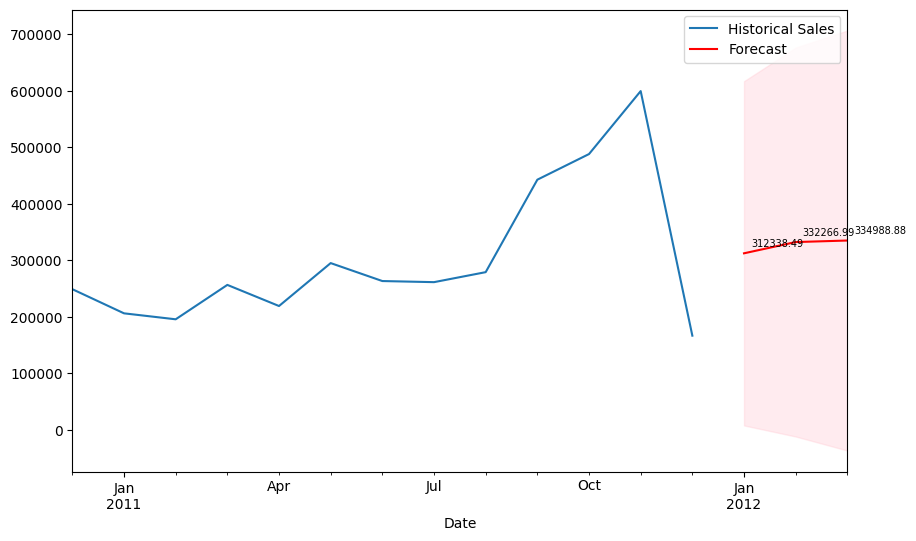

In [ ]:
# Forecast for the next 3 months
forecast_arima = arima_result.get_forecast(steps=3)

# Get confidence intervals
forecast_ci = forecast_arima.conf_int()

# Print forecasted sales and confidence intervals
print(forecast_arima.predicted_mean)
print(forecast_ci)

# Plot the forecast along with historical data
ax = monthly_sales.plot(label='Historical Sales', figsize=(10, 6))
forecast_arima.predicted_mean.plot(ax=ax, label='Forecast', color='red')

# Fill the confidence interval
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

# Annotate the forecasted values near the vertices
for x, y in zip(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean):
    ax.annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                textcoords='offset points', color='black', fontsize=7)

# Add legend and show plot
plt.legend()
plt.show()

MAE: 216777.69
RMSE: 239446.54
R²: -0.22
MAPE: 105.27%


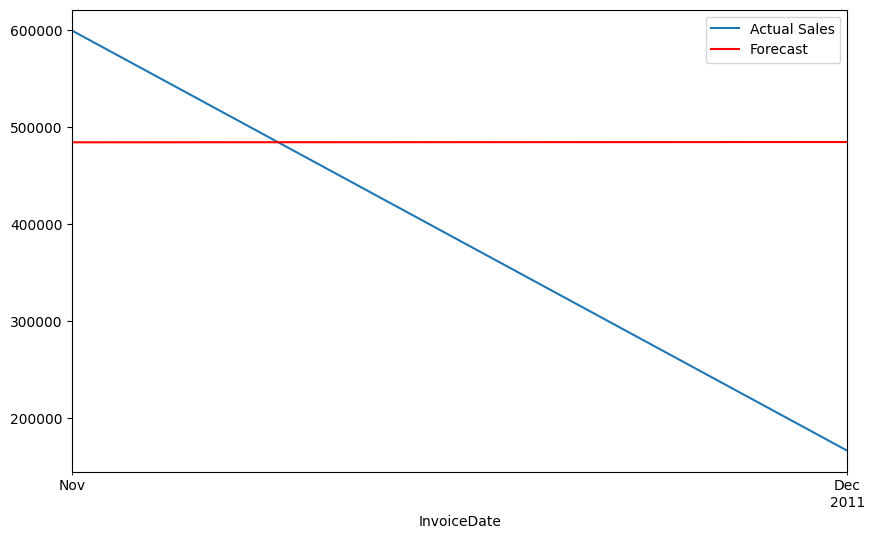

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train-test split (e.g., last 12 months as the test set)
train_size = int(len(monthly_sales) * 0.9)
train_data, test_data = monthly_sales[:train_size], monthly_sales[train_size:]

# Fit ARIMA model on training data
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_result = arima_model.fit()

# Generate predictions for the test set
forecast_arima = arima_result.get_forecast(steps=len(test_data))
forecast_values = forecast_arima.predicted_mean

# Get the test set values
test_values = test_data.values

# Calculate MAE
mae = mean_absolute_error(test_values, forecast_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_values, forecast_values))

# Calculate R²
r2 = r2_score(test_values, forecast_values)

# Calculate MAPE
mape = np.mean(np.abs((test_values - forecast_values) / test_values)) * 100

# Print metrics
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot actual vs forecast
ax = test_data.plot(label='Actual Sales', figsize=(10, 6))
forecast_values.plot(ax=ax, label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(monthly_sales)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.5667165041626148
p-value: 0.10007323714026561
